In [37]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as kpss
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

### Считываем данные

In [38]:
df = pd.read_csv('spending_by_day.csv')
df['date'] = pd.to_datetime(df.date, errors='coerce')
df.set_index('date', inplace=True)
df.head()

,sum
date,
2018-01-01,1.897892e+06
2018-01-02,5.438664e+06
2018-01-03,5.628547e+06
2018-01-04,6.056366e+06
2018-01-05,6.064084e+06


### Посмотрим на временной ряд

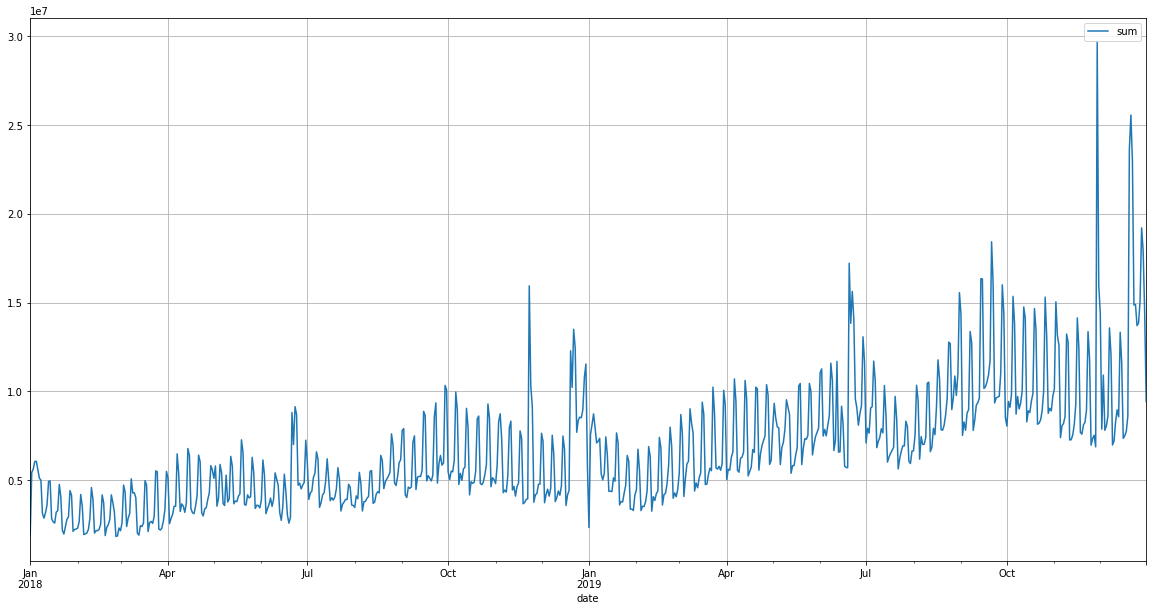

In [39]:
df.plot(figsize=(20,10))
plt.grid()

### Изначальная предобработка данных

Проверка на пропущенные данные

In [40]:
df.isnull().sum()

sum    0
dtype: int64

Пропусков нет

Формируем обучающую и тестовую выборки

In [41]:
train_data = df[:'2019-09-01']
test_data = df['2019-09-01':]

In [42]:
# Уменьшаем дисперсию для нестационарного ряда
sum_t = train_data.copy()
sum_t = np.asarray(sum_t)
sum_t = sum_t.flatten()

# значения сумм после преобразования Бокса-Кокса
sum_t, _ = stats.boxcox(sum_t)

train_data_t = train_data.copy()
train_data_t.iloc[:] = sum_t.reshape((len(sum_t),1))

In [43]:
train_data_t.head()

,sum
date,
2018-01-01,29.576344
2018-01-02,33.603176
2018-01-03,33.740932
2018-01-04,34.036422
2018-01-05,34.041576


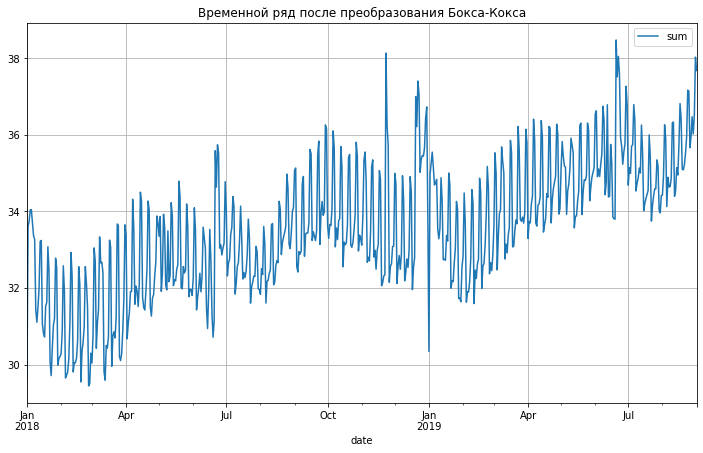

In [44]:
train_data_t.plot(figsize=(12,7))
plt.grid()
plt.title('Временной ряд после преобразования Бокса-Кокса');

### Сезонное дифференцирование  
Сезонность видна каждые полгода, поэтому дифференцируем с шагом 6 (=сдвиг на 6 месяцев) 

In [45]:
diff_season = []
for i in range(6, len(train_data_t)):
    diff_season.append(train_data_t.iloc[i] - train_data_t.iloc[i - 6])

Дифференцированный с учетом сезонности график

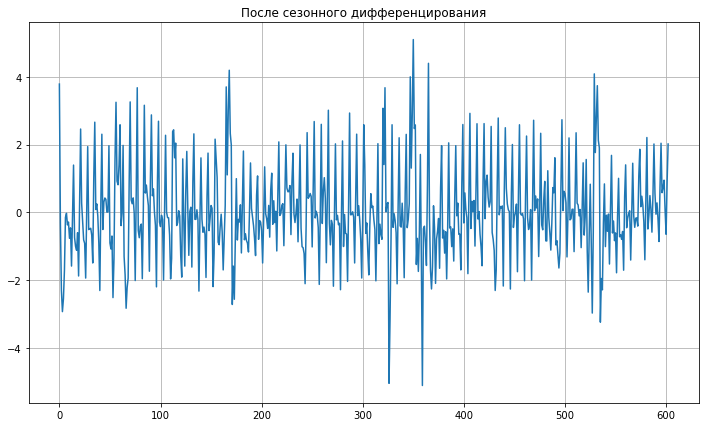

In [46]:
plt.figure(figsize=(12,7))
plt.plot(diff_season)
plt.grid()
plt.title('После сезонного дифференцирования');

Визуально данный график уже больше похож на стационарный  
Проверим это с помощью kpss 

In [47]:
print(sm.tsa.stattools.kpss(diff_season, regression='c')[0:2])

(0.09490294882475979, 0.1)


Значение 0.1 говорит нам о том, что график стационарный.  
Таким образом, однократного сезонного дифференцирования оказалось достаточно для обеспечения стационарности временного ряда.


Параметр d=0, D=1 (дифференцирование тренда не проводилось, дифференцирование сезонности проводилось один раз)

Посмотрим на автокорреляцию и частичную автокорреляцию графика после дифференцирования сезонности

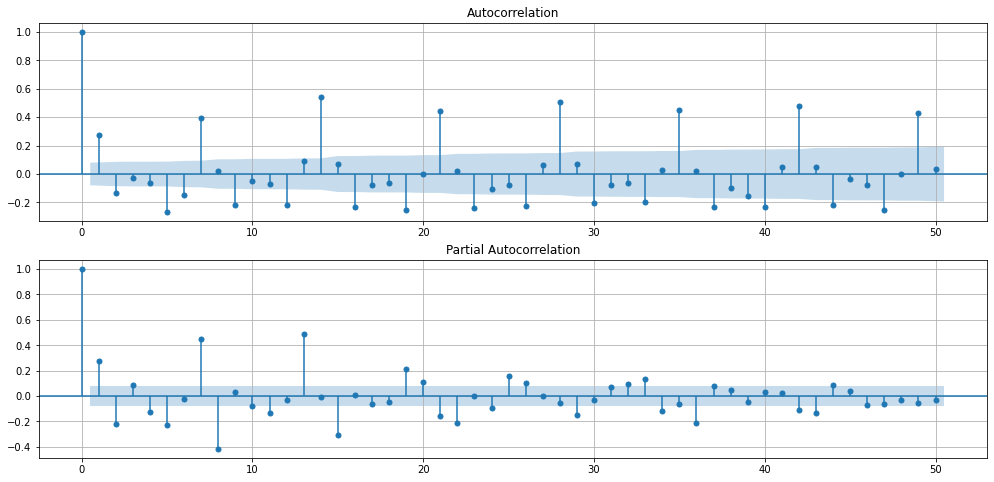

In [48]:
fig = plt.figure(figsize=(17,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_season, lags=50, ax=ax1)
plt.grid()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_season, lags=50, ax=ax2)
plt.grid()

Исходя из графиков можно подобрать следующие значения  
Q = 4 (сезонный лаг на графике автокорреляции)  
P = 3 (сезонный лаг на графике частичной автокорреляции)  
  
q = 5 (несезонный лаг на графике автокорреляции)  
p = 5 (несезонный лаг на графике частичной автокорреляции)


Однако лучшим способом будет подбор параметров для модели методом перебора 

In [49]:
import itertools
from tqdm import tqdm_notebook

p = range(3,6)
d = [0]
q = range(3,6)
P = range(2,4)
D = [1]
Q = range(3,5)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(P,D,Q))]

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        try:
            model = sm.tsa.statespace.SARIMAX(train_data, order=param, seasonal_order=param_seasonal)
            model = model.fit()
            print('ARIMA{}x{} – AIC: {:.2f}'.format(param,param_seasonal,model.aic))
        except:
            print('no model')
            continue

ARIMA(3, 0, 3)x(2, 1, 3, 6) – AIC: 18939.12
ARIMA(3, 0, 3)x(2, 1, 4, 6) – AIC: 18932.96
ARIMA(3, 0, 3)x(3, 1, 3, 6) – AIC: 18930.92
ARIMA(3, 0, 3)x(3, 1, 4, 6) – AIC: 18893.95


ARIMA(3, 0, 4)x(2, 1, 3, 6) – AIC: 18941.49
ARIMA(3, 0, 4)x(2, 1, 4, 6) – AIC: 18910.31
ARIMA(3, 0, 4)x(3, 1, 3, 6) – AIC: 18913.00
ARIMA(3, 0, 4)x(3, 1, 4, 6) – AIC: 18918.46


ARIMA(3, 0, 5)x(2, 1, 3, 6) – AIC: 18898.28
ARIMA(3, 0, 5)x(2, 1, 4, 6) – AIC: 18900.74
ARIMA(3, 0, 5)x(3, 1, 3, 6) – AIC: 18900.12
ARIMA(3, 0, 5)x(3, 1, 4, 6) – AIC: 18904.37


ARIMA(4, 0, 3)x(2, 1, 3, 6) – AIC: 18832.06
ARIMA(4, 0, 3)x(2, 1, 4, 6) – AIC: 18834.61
ARIMA(4, 0, 3)x(3, 1, 3, 6) – AIC: 18865.51
ARIMA(4, 0, 3)x(3, 1, 4, 6) – AIC: 18844.68


ARIMA(4, 0, 4)x(2, 1, 3, 6) – AIC: 18897.43
ARIMA(4, 0, 4)x(2, 1, 4, 6) – AIC: 18901.93
ARIMA(4, 0, 4)x(3, 1, 3, 6) – AIC: 18898.90
ARIMA(4, 0, 4)x(3, 1, 4, 6) – AIC: 18901.60


ARIMA(4, 0, 5)x(2, 1, 3, 6) – AIC: 18891.94
ARIMA(4, 0, 5)x(2, 1, 4, 6) – AIC: 18897.77
ARIMA(4, 0, 5)x(3, 1, 3, 6) – AIC: 18891.90
ARIMA(4, 0, 5)x(3, 1, 4, 6) – AIC: 18894.93


ARIMA(5, 0, 3)x(2, 1, 3, 6) – AIC: 18775.14
ARIMA(5, 0, 3)x(2, 1, 4, 6) – AIC: 18762.76
ARIMA(5, 0, 3)x(3, 1, 3, 6) – AIC: 18772.97
ARIMA(5, 0, 3)x(3, 1, 4, 6) – AIC: 18778.87


ARIMA(5, 0, 4)x(2, 1, 3, 6) – AIC: 18867.22
ARIMA(5, 0, 4)x(2, 1, 4, 6) – AIC: 18877.94
ARIMA(5, 0, 4)x(3, 1, 3, 6) – AIC: 18850.42
ARIMA(5, 0, 4)x(3, 1, 4, 6) – AIC: 18839.59


ARIMA(5, 0, 5)x(2, 1, 3, 6) – AIC: 18812.99
ARIMA(5, 0, 5)x(2, 1, 4, 6) – AIC: 18815.35
ARIMA(5, 0, 5)x(3, 1, 3, 6) – AIC: 18814.44
ARIMA(5, 0, 5)x(3, 1, 4, 6) – AIC: 18819.60



При выборе параметров модели ориентируемся на значение AIC, выбираем те параметры, для которых AIC меньше  
Тест показал, что мы можем использовать следующие параметры:  
Q = 4  
P = 2 

q = 3  
p = 5

### Обучаем модель

In [50]:
model_new = sm.tsa.statespace.SARIMAX(train_data, order=(5,0,3), seasonal_order=(2,1,4,6))
model_new = model_new.fit()

Смотрим, как модель ведет себя на обучающем наборе

In [51]:
pred = model_new.predict('2019-07-01','2019-09-01', typ='levels')

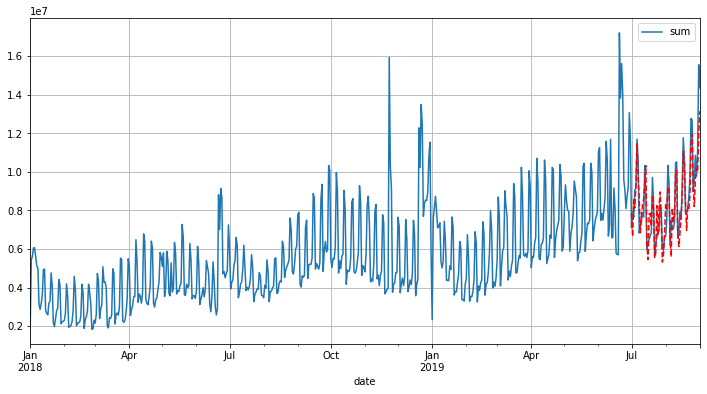

In [52]:
train_data.plot(figsize=(12,6))
pred.plot(style='r--')
plt.grid()

Предскажем значения на тестовом наборе 

In [53]:
pred_test = model_new.predict('2019-09-01','2019-12-31', typ='levels')

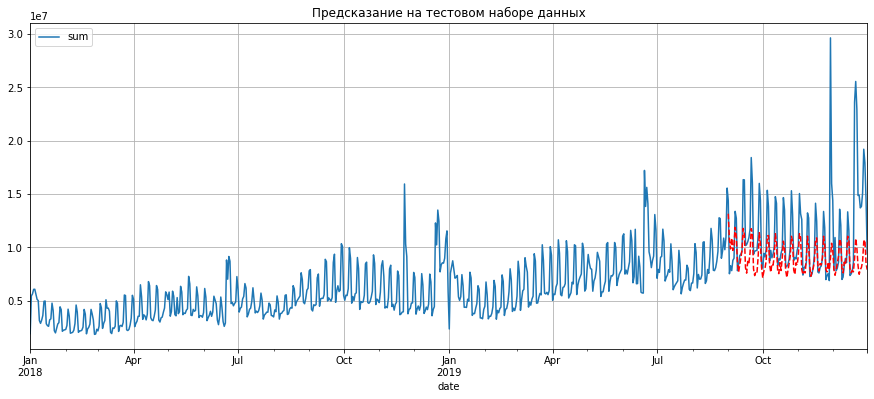

In [54]:
df.plot(figsize=(15,6))
pred_test.plot(style='r--')
plt.grid()
plt.title('Предсказание на тестовом наборе данных');

На тестовом наборе данных модель справляется значительно хуже

Проанализируем получившуюся модель

In [55]:
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                          sum   No. Observations:                  609
Model:             SARIMAX(5, 0, 3)x(2, 1, [1, 2, 3, 4], 6)   Log Likelihood               -9366.378
Date:                                      Tue, 29 Jun 2021   AIC                          18762.756
Time:                                              15:55:58   BIC                          18828.784
Sample:                                          01-01-2018   HQIC                         18788.454
                                               - 09-01-2019                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8299      0.303      2.739      0.006       0.236       1.424
ar.L2          0.3582      0.561      0.638      0.524      -0.742       1.459
ar.L3         -1.1817      0.457     -2.587      0.010      -2.077      -0.287
ar.L4          0.4945      0.133      3.728      0.000       0.235       0.754
ar.L5          0.2704      0.102      2.647      0.008       0.070       0.471
ma.L1         -0.2561      0.300     -0.852      0.394      -0.845       0.333
ma.L2         -0.3033      0.387     -0.784      0.433      -1.061       0.455
ma.L3          0.9110      0.285      3.201      0.001       0.353       1.469
ar.S.L6       -0.4349      0.037    -11.699      0.000      -0.508      -0.362
ar.S.L12      -0.9700      0.035    -28.040      0.000      -1.038      -0.902
ma.S.L6       -0.7200      0.132     -5.464      0.000      -0.978      -0.462
ma.S.L12       0.6194      0.128      4.838      0.000       0.368       0.870
ma.S.L18      -0.8792      0.125     -7.049      0.000      -1.124      -0.635
ma.S.L24       0.1509      0.111      1.363      0.173      -0.066       0.368
sigma2      2.828e+12   5.04e-13   5.61e+24      0.000    2.83e+12    2.83e+12
===================================================================================
Ljung-Box (L1) (Q):                   3.44   Jarque-Bera (JB):             12591.15
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                             2.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+41. Standard errors may be unstable.
"""

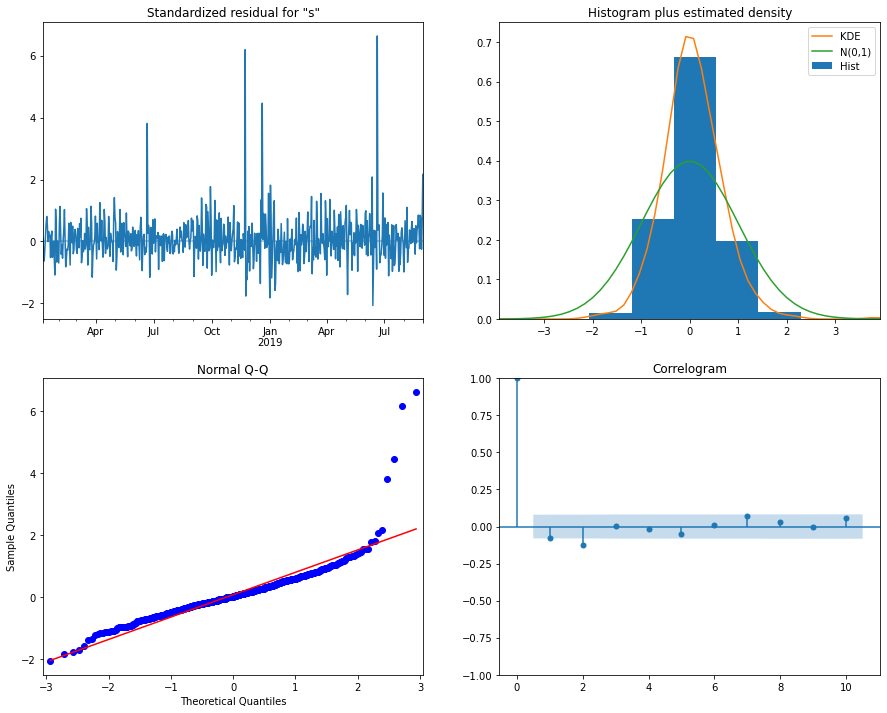

In [56]:
model_new.plot_diagnostics(figsize=(15, 12))
plt.show()

QQ график показывает, что в модели есть выбросы - скорее всего распределение остатков не нормальное.  
Такие же выводы можно сделать, глядя на график KDE (график стандартного нормального распределения и KDE не накладываются, а расположены "далеко" друг от друга)  
Визуально сами остатки (верхний левый график) не похожи на белый шум, есть выбросы  
Наконец, есть корреляция между остатками, что тоже говорит не в пользу нормальности их распределения.  
  
Полученная сезонная модель ARIMA (SARIMA) не справляется должным образом с предсказанием временных рядов и нуждается в улучшении. Может быть проведен более детальный подбор параметров/определение и удаление выбросов в исходном ряде + дополнительное дифференцирование (было выполнено только сезонное дифференцирование).